In [1]:
%matplotlib inline

In [14]:
import os
import LFPy
import MEAutility as mu
import neuron
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


In [3]:
# os.system('''
#               cd purkinje_pub
#               nrnivmodl
#               ''')
neuron.load_mechanisms('purkinje_pub')

True

In [4]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : './my_purkinje_morph.hoc',
    # 'cm' : 0.64,                 # membrane capacitance # already defined in my_custom_code.hoc
    # 'Ra' : 120,                 # axial resistance # already defined in my_custom_code.hoc
    # 'v_init' : -65,             # initial crossmembrane potential
    'passive' : False,           # turn on passive mechanism
    # 'passive_parameters' : {'g_pas' : 1./120236, 'e_pas' : -65}, # passive params # we defined different params for secs in my_custom_code.hoc
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 500,           # segments are isopotential at this frequency
    'dt' : 2**-6,               # dt of LFP and NEURON simulation.
    'tstart' : -50,             # start time, recorders start at t=0
    'tstop' : 100,               # stop time of simulation
    'custom_code'  : ['./purkinje_pub/my_custom_code.hoc'], # will run this file
    'celsius':34,
    'pt3d':True,
    'verbose':True
}

## Recording

In [5]:
# Generate the grid in xz-plane over which we calculate local field potentials
X,Y = np.mgrid[-5:25,-5:25] * 10
Z = np.zeros(X.shape) * 10

# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,              # extracellular conductivity
    'x' : X.flatten(),        # x,y,z-coordinates of contact points
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'root_as_point',  #treat soma segment as sphere source
}

In [6]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)
# set the position of midpoint in soma to Origo (not needed, this is the default)
cell.set_pos(x=0, y=0, z=0)

0 existing sections deleted from memory
	1 
	30 
	0 
	0 
	0 
	0 
Purkinje cell morphology defined

	1 
No passive properties added
no extracellular mechanism inserted
set nsegs using lambda-rule with frequency 500.
Total number of segments: 2503
Changing temperature 34.00 to 34.00
6.934542
6.549290
6.164037
5.778785
5.393533
5.008280
4.623028
4.237776
3.852523
3.467271
3.082019
2.696766
2.311514
1.926262
1.541009
1.155757
0.770505
0.385252


In [7]:
# create extracellular electrode object
electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

In [8]:
# Synaptic parameters, corresponding to a NetCon synapse built into NEURON
# Excitatory synapse parameters:
synapseParameters_AMPA = {
    'e' : 0,                    #reversal potential
    'syntype' : 'Exp2Syn',      #conductance based exponential synapse
    'tau1' : 1.,                #Time constant, rise
    'tau2' : 3.,                #Time constant, decay
    'weight' : 0.005,           #Synaptic weight
    'record_current' : True,    #record synaptic currents
}
# Excitatory synapse parameters
synapseParameters_NMDA = {         
    'e' : 0,
    'syntype' : 'Exp2Syn',
    'tau1' : 10.,
    'tau2' : 30.,
    'weight' : 0.005,
    'record_current' : True,
}

# where to insert, how many, and which input statistics
insert_synapses_AMPA_args = {
    'section' : cell.allsecnames[2:],
    'n' : 50, 
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=0.5, loc=0., scale=40)
                  )
}
insert_synapses_NMDA_args = {
    'section' : cell.allsecnames[2:],
    'n' : 3, 
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=2, loc=0, scale=50)
                  )
}

In [9]:
def insert_synapses(synparams, section, n, spTimesFun, args):
    '''find n compartments to insert synapses onto'''
    idx = cell.get_rand_idx_area_norm(section=section, nidx=n)

    # Some input spike train using the function call
    # [spiketimes] = spTimesFun(**args)
    

    #Insert synapses in an iterative fashion
    for i in idx:
        synparams.update({'idx' : int(i)})

        spiketimes = np.array([5]) + np.random.randn() * 0.5
        
        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synparams)
        s.set_spike_times(spiketimes)

# attach synapse with parameters and set spike time
insert_synapses(synapseParameters_AMPA, **insert_synapses_AMPA_args)
insert_synapses(synapseParameters_NMDA, **insert_synapses_NMDA_args)

# perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(probes=[electrode])

Adjusting r-distance to root segments


In [10]:
def plot_ex2(cell, electrode):
    # creating array of points and corresponding diameters along structure
    for i in range(cell.x.shape[0]):
        if i == 0:
            xcoords = np.array([cell.x[i].mean()])
            ycoords = np.array([cell.y[i].mean()])
            zcoords = np.array([cell.z[i].mean()])
            diams = np.array([cell.d[i]])
        else:
            # if cell.z[i].mean() < 100 and cell.z[i].mean() > -100 and \
            #         cell.x[i].mean() < 100 and cell.x[i].mean() > -100:
            if True:
                xcoords = np.r_[xcoords,
                                np.linspace(cell.x[i, 0],
                                            cell.x[i, 1],
                                            int(cell.length[i] * 3))]
                ycoords = np.r_[ycoords,
                                np.linspace(cell.y[i, 0],
                                            cell.y[i, 1],
                                            int(cell.length[i] * 3))]
                zcoords = np.r_[zcoords,
                                np.linspace(cell.z[i, 0],
                                            cell.z[i, 1],
                                            int(cell.length[i] * 3))]
                diams = np.r_[diams,
                              np.linspace(cell.d[i], cell.d[i],
                                          int(cell.length[i] * 3))]

    argsort = np.argsort(zcoords)

    # plotting
    fig = plt.figure(figsize=[24, 16])
    ax = fig.add_axes([0.1, 0.1, 0.533334, 0.8], frameon=False)
    ax.scatter(xcoords[argsort], ycoords[argsort], s=diams[argsort]**2 * 20,
               c=zcoords[argsort], edgecolors='none', cmap='gray')
    ax.plot(electrode.x, electrode.y, 'o', markersize=5, color='k')

    for i in range(len(cell.synapses)):
        ax.plot([cell.synapses[i].x], [cell.synapses[i].y], marker='.',
                color='r'
                )

    i = 0
    for LFP in electrode.data:
        tvec = cell.tvec * 0.05 + electrode.x[i] + 2
        if abs(LFP).max() >= 1:
            factor = 2
            color = 'r'
        elif abs(LFP).max() < 0.25:
            factor = 50
            color = 'b'
        else:
            factor = 10
            color = 'g'
        trace = LFP * factor + electrode.y[i]
        ax.plot(tvec, trace, color=color, lw=2)
        i += 1

    ax.plot([22, 23], [-60, -60], color='k', lw=3)
    ax.text(22, -65, '20 ms')

    ax.plot([40, 50], [-60, -60], color='k', lw=3)
    ax.text(42, -65, r'10 $\mu$m')

    ax.plot([250, 250], [20, 30], color='r', lw=2)
    ax.text(250+2, 20, '5 mV')

    ax.plot([250, 250], [0, 10], color='g', lw=2)
    ax.text(250+2, 0, '1 mV')

    ax.plot([250, 250], [-20, -10], color='b', lw=2)
    ax.text(250+2, -20, '0.1 mV')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.axis([-61, 250+1, -61, 250+1])

    ax.set_title('Location-dependent extracellular spike shapes')

    

    # plotting the soma trace
    ax = fig.add_axes([0.75, 0.7, 0.2, 0.25])
    ax.plot(cell.tvec, cell.somav)
    ax.set_title('Somatic action-potential')
    ax.set_ylabel(r'$V_\mathrm{membrane}$ (mV)')

    # plotting electrode trace
    ax = fig.add_axes([0.75, 0.375, 0.2, 0.25])
    [ax.plot(cell.tvec, LFP) for LFP in electrode.data]
    ax.set_title('Electrode trace')
    ax.set_ylabel(r'$V_\mathrm{electrode}$ (mV)')

    # plotting the synaptic current
    ax = fig.add_axes([0.75, 0.05, 0.2, 0.25])
    [ax.plot(cell.tvec, cell.synapses[i].i) for i in range(len(cell.synapses))]
    ax.set_title('Synaptic current')
    ax.set_ylabel(r'$i_\mathrm{synapse}$ (nA)')
    ax.set_xlabel(r'time (ms)')

    return fig

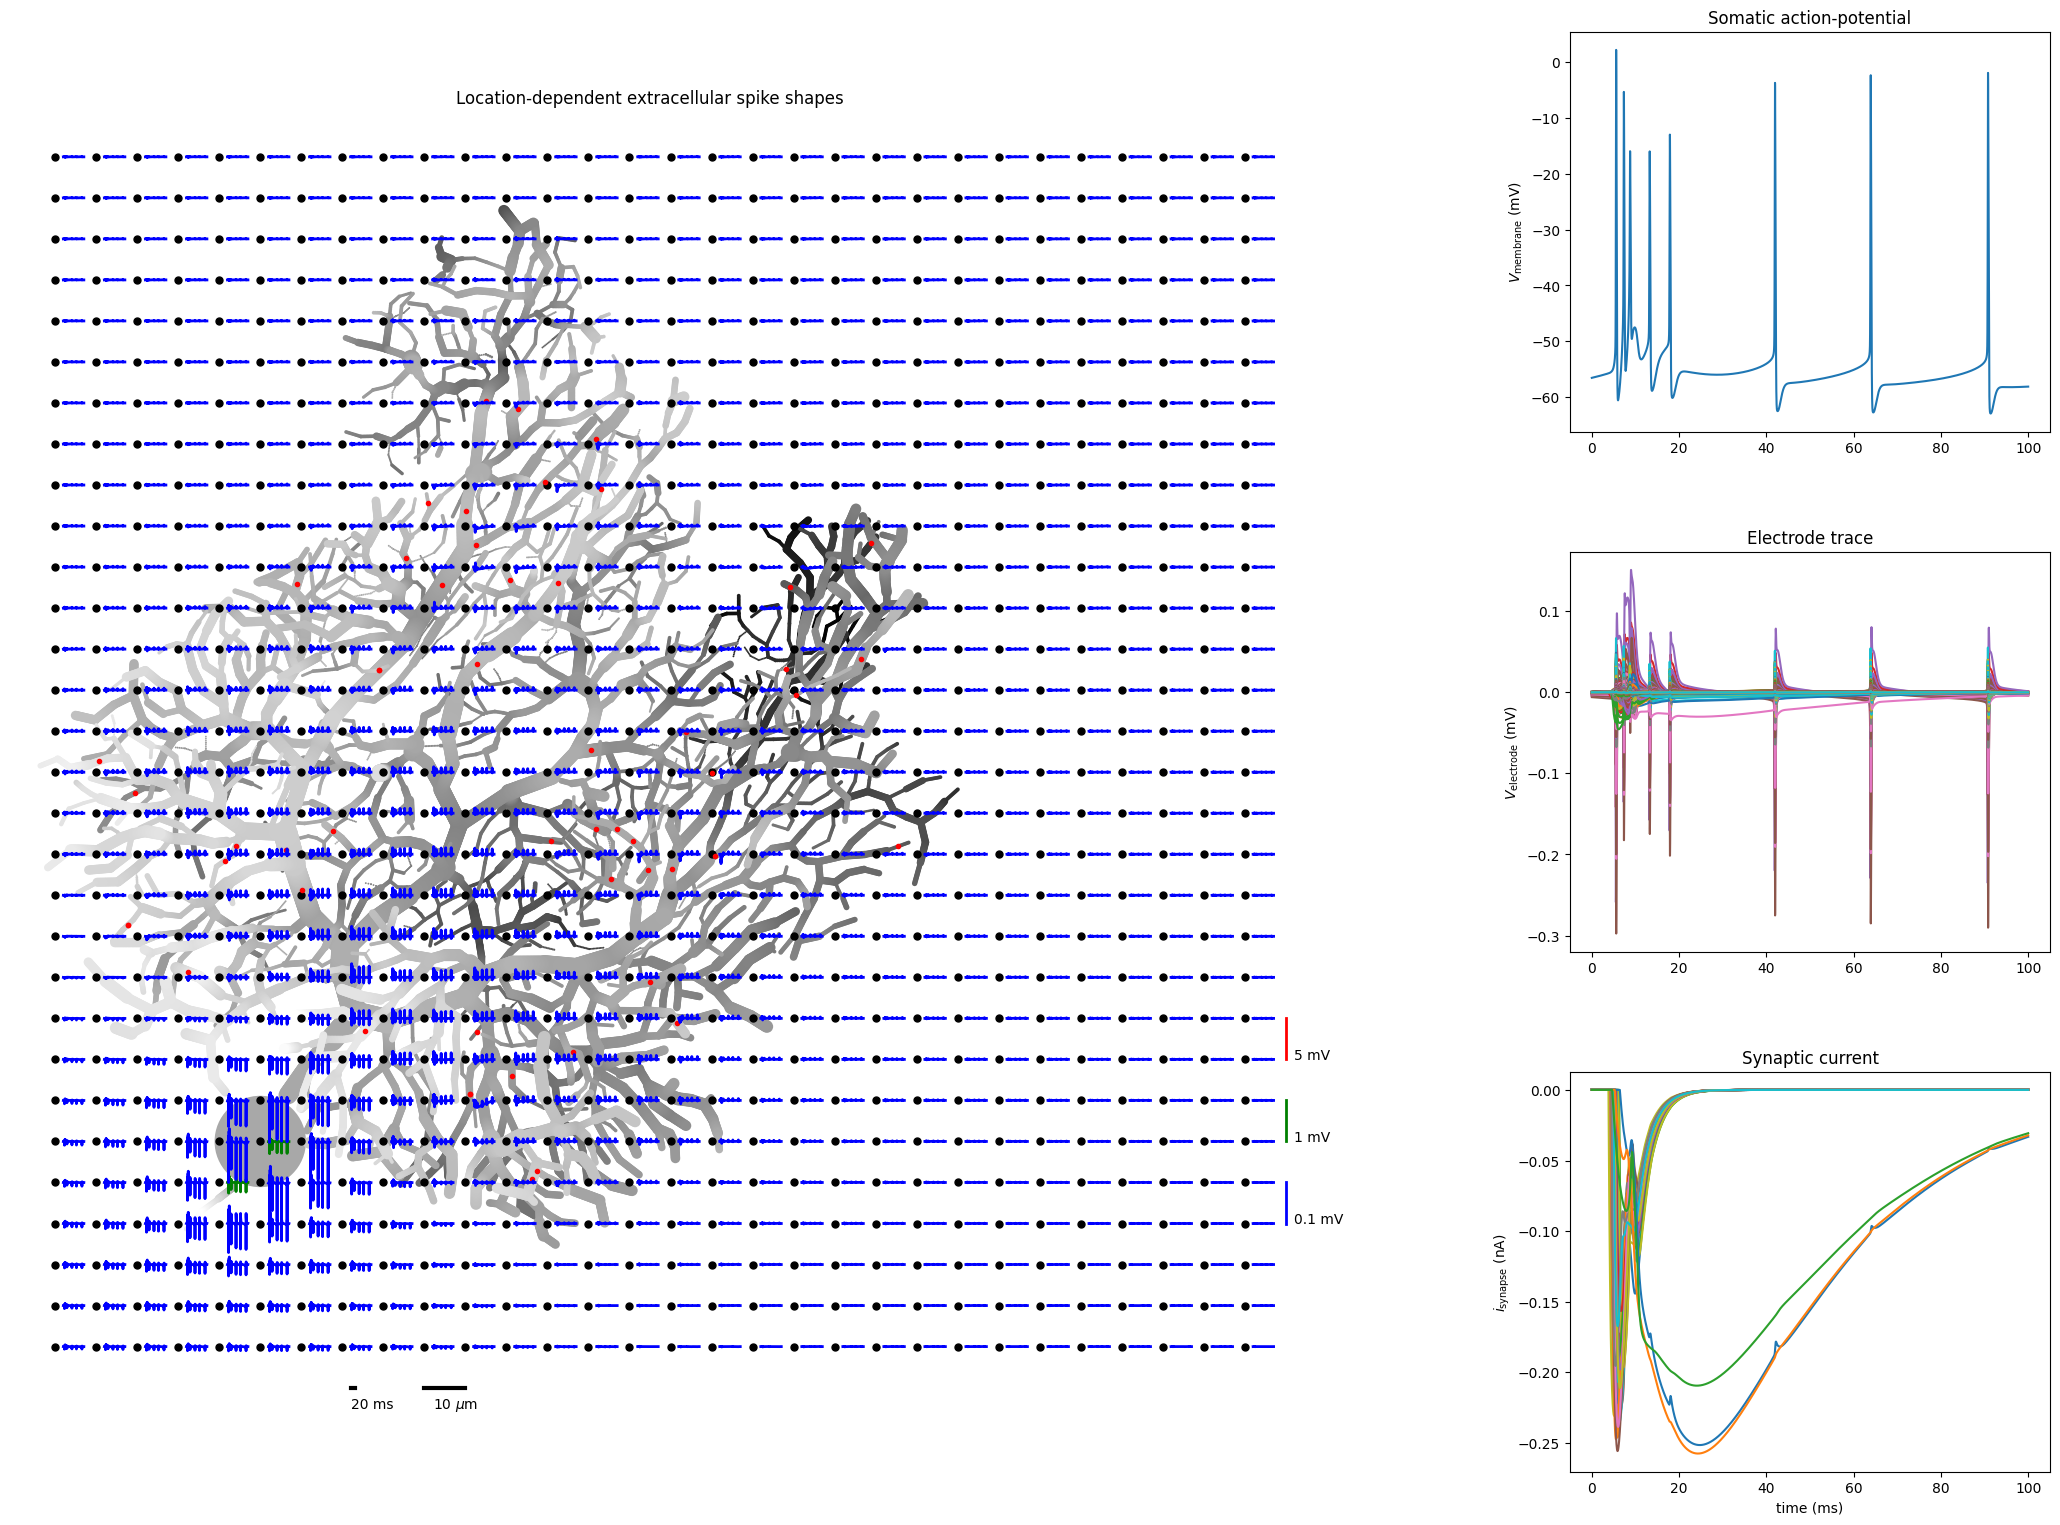

In [11]:
fig = plot_ex2(cell, electrode)

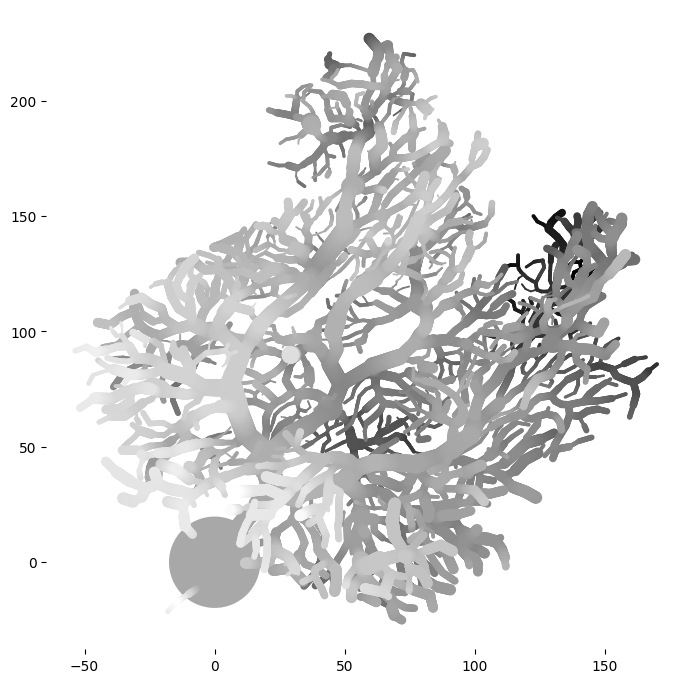

In [12]:
for i in range(cell.x.shape[0]):
        if i == 0:
            xcoords = np.array([cell.x[i].mean()])
            ycoords = np.array([cell.y[i].mean()])
            zcoords = np.array([cell.z[i].mean()])
            diams = np.array([cell.d[i]])
        else:
            xcoords = np.r_[xcoords,
                                np.linspace(cell.x[i, 0],
                                            cell.x[i, 1],
                                            int(cell.length[i] * 3))]
            ycoords = np.r_[ycoords,
                                np.linspace(cell.y[i, 0],
                                            cell.y[i, 1],
                                            int(cell.length[i] * 3))]
            zcoords = np.r_[zcoords,
                                np.linspace(cell.z[i, 0],
                                            cell.z[i, 1],
                                            int(cell.length[i] * 3))]
            diams = np.r_[diams,
                              np.linspace(cell.d[i], cell.d[i],
                                          int(cell.length[i] * 3))]

argsort = np.argsort(zcoords)

# plotting
fig = plt.figure(figsize=[12, 8])
ax = fig.add_axes([0.1, 0.1, 0.533334, 0.8], frameon=False)
ax.scatter(xcoords[argsort], ycoords[argsort], s=diams[argsort]**2 * 20,
               c=zcoords[argsort], edgecolors='none', cmap='gray')

In [13]:
print('debug')

debug


## Stimulation

In [57]:
probe = mu.return_mea('monotrode')
# probe.rotate(axis=[0, 0, 1], theta=90)
probe.move([105, 105, 0])

(0.0, 100.0)

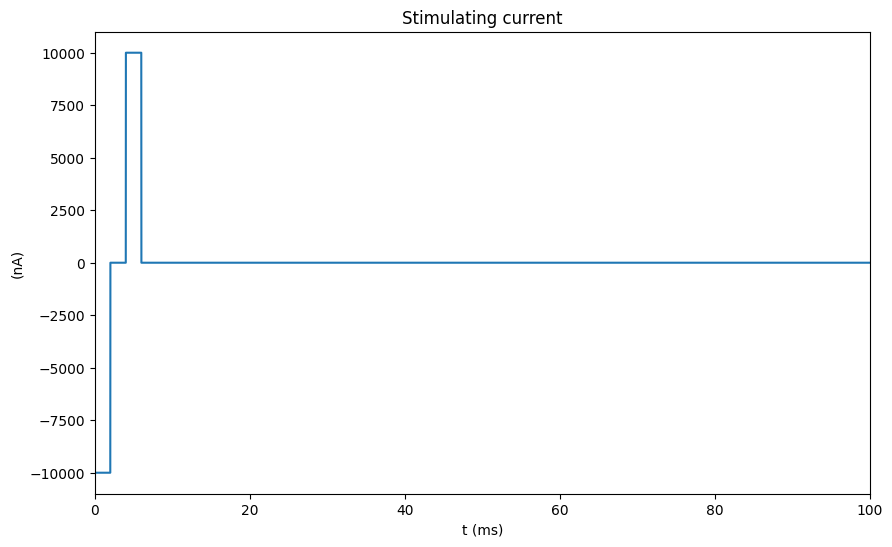

In [58]:
# create a pulse stimulation current
amp = -10000
n_pulses = 1
interpulse = 10
interphase = 2
width = 2
dt = cell.dt
t_stop = cell.tstop
t_start = 0
stim_elec = 0

current, t_ext = probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, t_stop=t_stop,
                                          t_start=t_start, n_pulses=n_pulses, interpulse=interpulse,
                                          biphasic=True, interphase=interphase)

plt.figure(figsize=(10, 6))
plt.plot(t_ext, current)
plt.title("Stimulating current")
plt.xlabel('t (ms)')
plt.ylabel('(nA)')
plt.xlim(0, cell.tstop)

In [59]:
cell = LFPy.Cell(**cellParameters)
cell.set_pos(x=0, y=0, z=0)

electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

stim_electrode = LFPy.RecExtElectrode(cell=cell, probe=probe)
v_ext = cell.enable_extracellular_stimulation(stim_electrode, t_ext=t_ext) 

cell.simulate(probes=[electrode,stim_electrode], rec_vmem=True)

1137 existing sections deleted from memory
	1 
	30 
	0 
	0 
	0 
	0 
Purkinje cell morphology defined

	1 
No passive properties added
no extracellular mechanism inserted
set nsegs using lambda-rule with frequency 500.
Total number of segments: 2503
Changing temperature 34.00 to 34.00
Adjusting r-distance to root segments


In [55]:
def plot_stimulation(cell,electrode,stim_electrode):

    # creating array of points and corresponding diameters along structure
    for i in range(cell.x.shape[0]):
        if i == 0:
            xcoords = np.array([cell.x[i].mean()])
            ycoords = np.array([cell.y[i].mean()])
            zcoords = np.array([cell.z[i].mean()])
            diams = np.array([cell.d[i]])
        else:
            # if cell.z[i].mean() < 100 and cell.z[i].mean() > -100 and \
            #         cell.x[i].mean() < 100 and cell.x[i].mean() > -100:
            if True:
                xcoords = np.r_[xcoords,
                                np.linspace(cell.x[i, 0],
                                            cell.x[i, 1],
                                            int(cell.length[i] * 3))]
                ycoords = np.r_[ycoords,
                                np.linspace(cell.y[i, 0],
                                            cell.y[i, 1],
                                            int(cell.length[i] * 3))]
                zcoords = np.r_[zcoords,
                                np.linspace(cell.z[i, 0],
                                            cell.z[i, 1],
                                            int(cell.length[i] * 3))]
                diams = np.r_[diams,
                              np.linspace(cell.d[i], cell.d[i],
                                          int(cell.length[i] * 3))]

    argsort = np.argsort(zcoords)

    # plotting
    fig = plt.figure(figsize=[24, 16])
    ax = fig.add_axes([0.1, 0.1, 0.533334, 0.8], frameon=False)
    ax.scatter(xcoords[argsort], ycoords[argsort], s=diams[argsort]**2 * 20,
               c=zcoords[argsort], edgecolors='none', cmap='gray')
    ax.plot(electrode.x, electrode.y, 'o', markersize=5, color='k')
    ax.plot(stim_electrode.x, stim_electrode.y, 'o', markersize=5, color='r')

    i = 0
    for LFP in electrode.data:
        tvec = cell.tvec * 0.05 + electrode.x[i] + 2
        if abs(LFP).max() >= 1:
            factor = 2
            color = 'r'
        elif abs(LFP).max() < 0.25:
            factor = 50
            color = 'b'
        else:
            factor = 10
            color = 'g'
        trace = LFP * factor + electrode.y[i]
        ax.plot(tvec, trace, color=color, lw=2)
        i += 1

    ax.plot([22, 23], [-60, -60], color='k', lw=3)
    ax.text(22, -65, '20 ms')

    ax.plot([40, 50], [-60, -60], color='k', lw=3)
    ax.text(42, -65, r'10 $\mu$m')

    ax.plot([250, 250], [20, 30], color='r', lw=2)
    ax.text(250+2, 20, '5 mV')

    ax.plot([250, 250], [0, 10], color='g', lw=2)
    ax.text(250+2, 0, '1 mV')

    ax.plot([250, 250], [-20, -10], color='b', lw=2)
    ax.text(250+2, -20, '0.1 mV')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.axis([-61, 250+1, -61, 250+1])

    ax.set_title('Location-dependent extracellular spike shapes')

    # plotting the soma trace
    ax = fig.add_axes([0.75, 0.7, 0.2, 0.25])
    ax.plot(cell.tvec, cell.somav)
    ax.set_title('Somatic action-potential')
    ax.set_ylabel(r'$V_\mathrm{membrane}$ (mV)')

    # plotting electrode trace
    ax = fig.add_axes([0.75, 0.375, 0.2, 0.25])
    [ax.plot(cell.tvec, LFP) for LFP in electrode.data]
    ax.set_title('Electrode trace')
    ax.set_ylabel(r'$V_\mathrm{electrode}$ (mV)')

    # plotting the synaptic current
    ax = fig.add_axes([0.75, 0.05, 0.2, 0.25])
    ax.plot(cell.tvec, np.concatenate([stim_electrode.probe.electrodes[0].current,[0]]))
    ax.set_title('Stimulating current')
    ax.set_ylabel('(nA)')
    ax.set_xlabel(r'time (ms)')


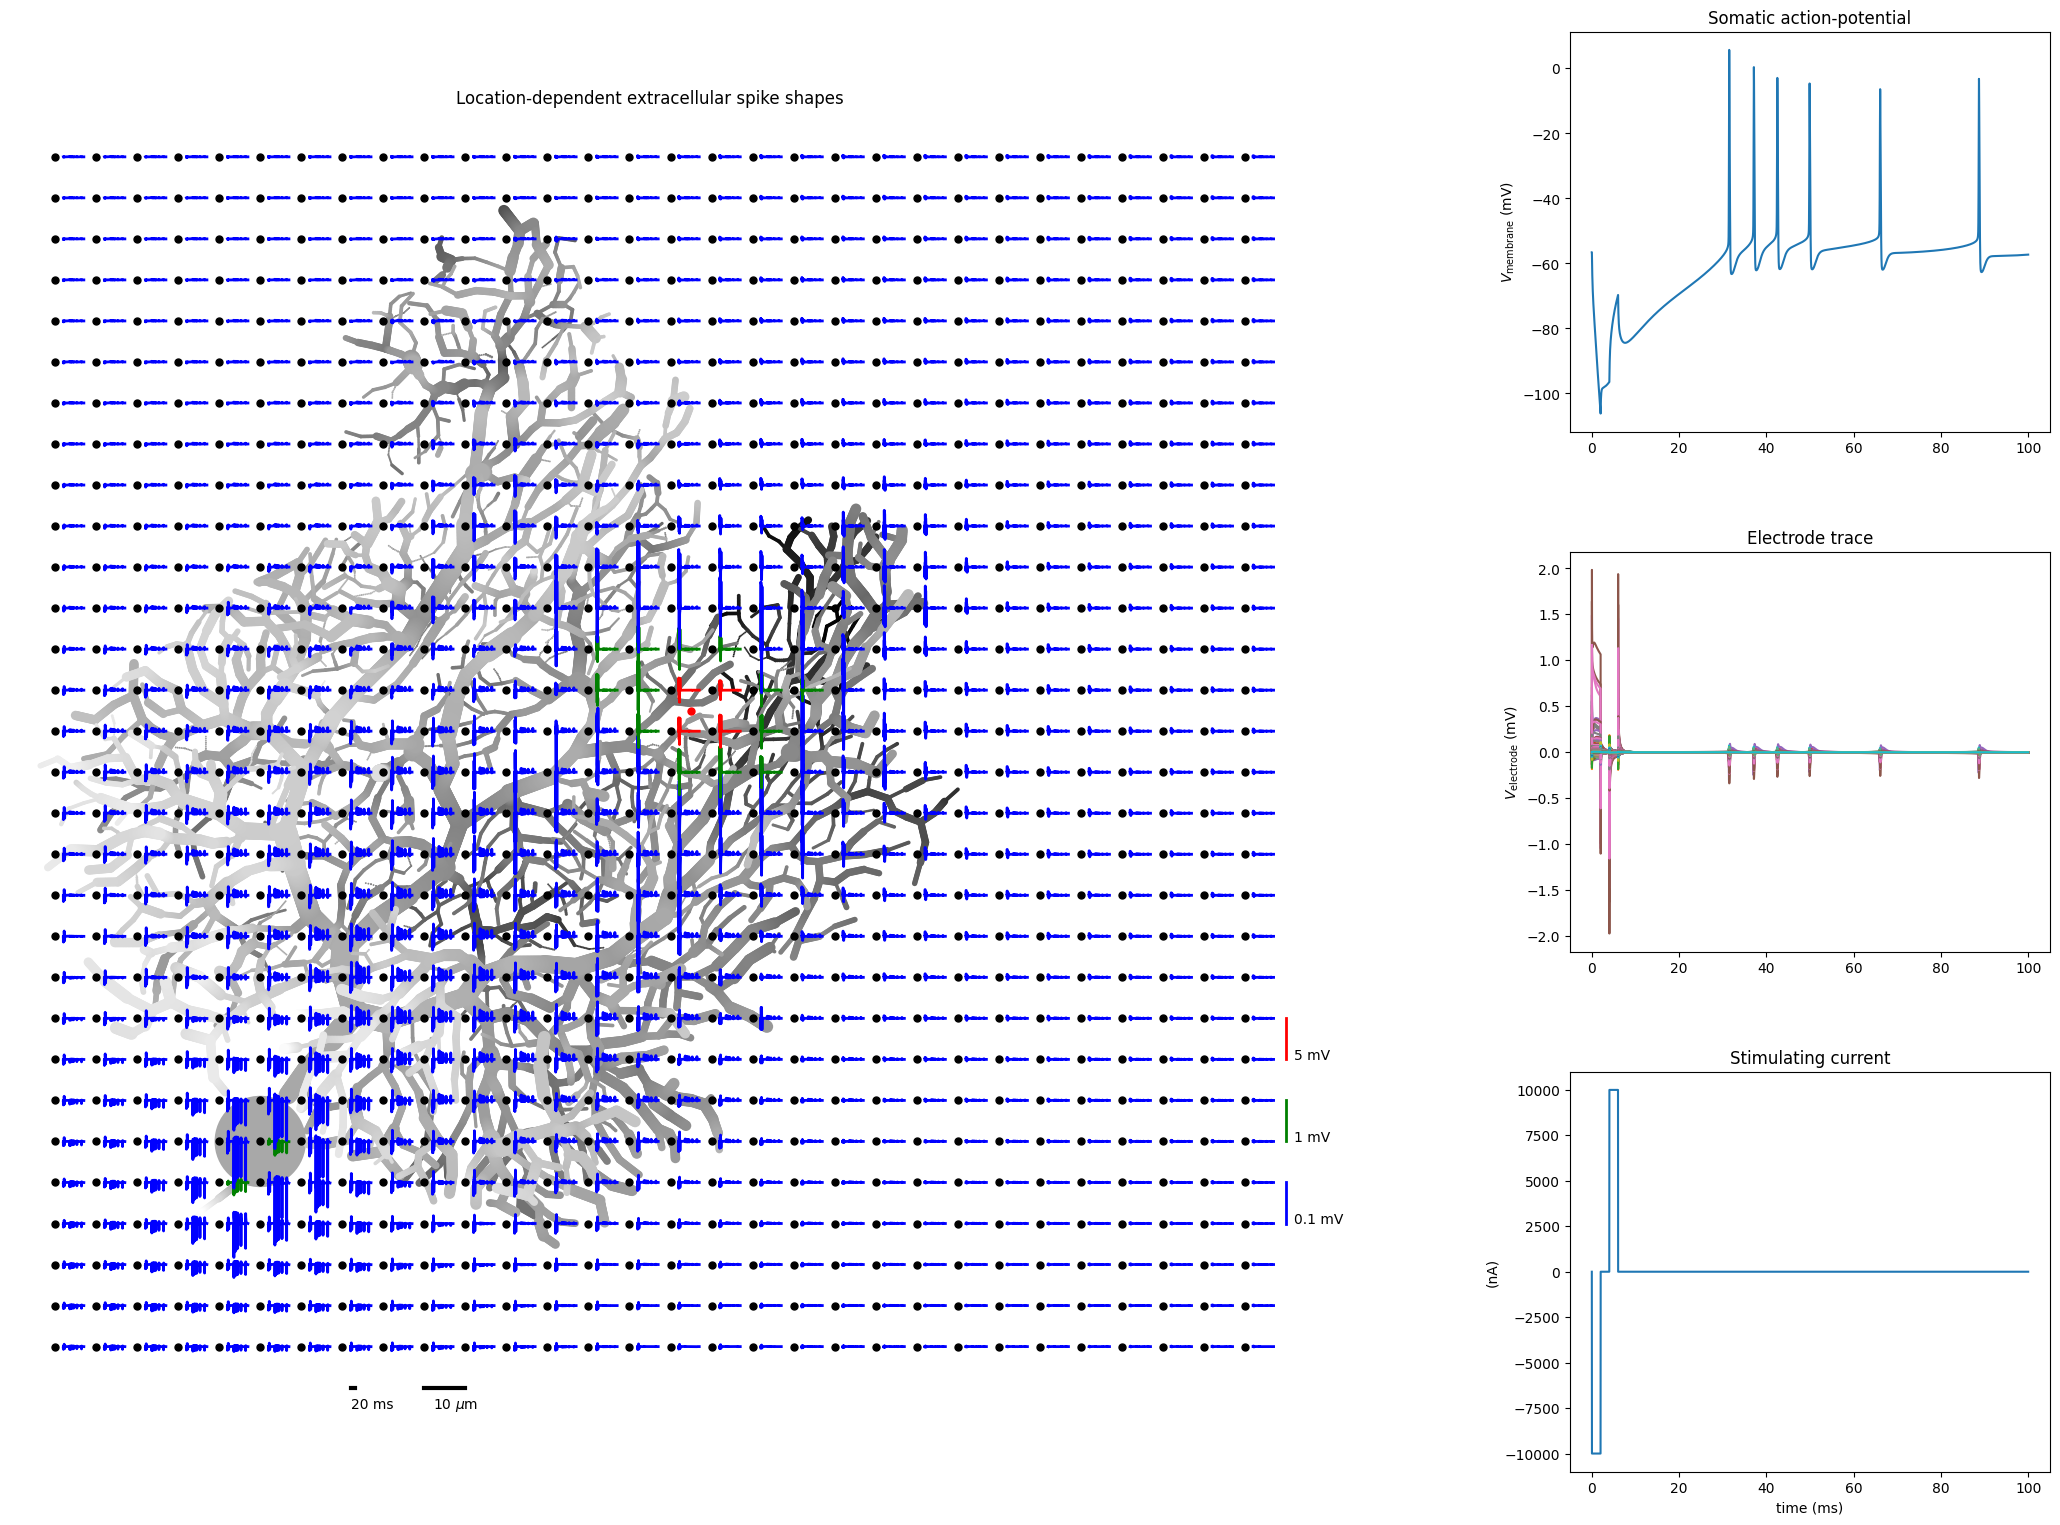

In [60]:
plot_stimulation(cell,electrode,stim_electrode)

In [54]:
print('debug')

debug
